<a href="https://colab.research.google.com/github/Shakil97/bangla-songs-lyrics-sentiment-analysis/blob/main/pyTorchTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==2.11.0

     |████████████████████████████████| 675kB 6.6MB/s 
     |████████████████████████████████| 890kB 10.9MB/s 
     |████████████████████████████████| 1.2MB 21.9MB/s 
     |████████████████████████████████| 5.6MB 17.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=afaed7ea1e911cdaebba13fc1cbe9daf00f293ff440517903b85b6b4c0d4bbe0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import pandas as pd
from google.colab import files

In [4]:
uploaded= files.upload()

Saving ReviseNewLyrics.csv to ReviseNewLyrics.csv


In [5]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "ReviseNewLyrics.csv" with length 182879 bytes


In [6]:
uploaded

{'ReviseNewLyrics.csv': b'title,category,lyrics,mood\r\n\xe0\xa6\x85\xe0\xa6\xaa\xe0\xa6\xb0\xe0\xa6\xbe\xe0\xa6\x9c\xe0\xa6\xbf\xe0\xa6\xa4,\xe0\xa6\xac\xe0\xa7\x8d\xe0\xa6\xaf\xe0\xa6\xbe\xe0\xa6\xa8\xe0\xa7\x8d\xe0\xa6\xa1,"\xe0\xa6\x8f\xe0\xa6\xac\xe0\xa6\xbe\xe0\xa6\xb0 \xe0\xa6\xa4\xe0\xa7\x8b\xe0\xa6\xae\xe0\xa6\xbe\xe0\xa6\xb0 \xe0\xa6\x95\xe0\xa6\xa5\xe0\xa6\xbe\xe0\xa6\x97\xe0\xa7\x81\xe0\xa6\xb2\xe0\xa7\x8b\xe0\xa6\xb0\n\xe0\xa6\x95\xe0\xa6\xbe\xe0\xa6\x9b\xe0\xa7\x87 \xe0\xa6\x86\xe0\xa6\xae\xe0\xa6\xbf \xe0\xa6\x85\xe0\xa6\xaa\xe0\xa6\xb0\xe0\xa6\xbe\xe0\xa6\x9c\xe0\xa6\xbf\xe0\xa6\xa4\n\xe0\xa6\x9c\xe0\xa6\xae\xe0\xa7\x87 \xe0\xa6\xa5\xe0\xa6\xbe\xe0\xa6\x95\xe0\xa6\xbe \xe0\xa6\xaf\xe0\xa6\xa4 \xe0\xa6\x85\xe0\xa6\xa8\xe0\xa7\x81\xe0\xa6\xad\xe0\xa7\x82\xe0\xa6\xa4\xe0\xa6\xbf \xe0\xa6\x86\xe0\xa6\xae\xe0\xa6\xbe\xe0\xa6\xb0\n\xe0\xa6\x9c\xe0\xa6\xb2 \xe0\xa6\xb0\xe0\xa6\x99\xe0\xa7\x87 \xe0\xa6\xb9\xe0\xa6\xbe\xe0\xa6\xb0\xe0\xa6\xbf\xe0\xa7\x9f\xe0\xa7\x87 \xe0\xa6\xaf

In [7]:
import io

In [8]:
df= pd.read_csv(io.StringIO(uploaded['ReviseNewLyrics.csv'].decode('utf-8')))
df.isnull().values.any()

df.shape

(107, 4)

In [9]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [10]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
df.head()

,title,category,lyrics,mood
0,অপরাজিত,ব্যান্ড,এবার তোমার কথাগুলোর\nকাছে আমি অপরাজিত\nজমে থাক...,বিষণ্ণতা
1,আমার ভায়ের রক্তে রাঙানো,দেশাত্মবোধক গান,আমার ভায়ের রক্তে রাঙানো একুশে ফেব্রুয়ারি\nআমি ...,বেদনা
2,আমার আপনার চেয়ে আপন যে জন,নজরুল গীতি,আমার আপনার চেয়ে আপন যে জন\nখুঁজি তারে আমি আপন...,তৃপ্তি
3,কেন চাঁদিনী রাতে মেঘ আসে ছায়া ক’রে,নজরুল গীতি,কেন চাঁদিনী রাতে মেঘ আসে ছায়া ক’রে।\nসুখের বা...,বিষণ্ণতা
4,কেন করুণ সুরে হৃদয়-পুরে বাজিছে বাঁশরি,নজরুল গীতি,কেন করুণ সুরে হৃদয়পুরে বাজিছে বাঁশরি\nঘনায় গ...,তেজোময়


In [ ]:
df.category.value_counts()

ছায়াছবি            95
নজরুল গীতি         36
আধুনিক             32
রবীন্দ্র সংগীত     30
ব্যান্ড            15
বাউল               11
Uncategorized       7
পল্লীগীতি           4
জীবনমুখী গান        4
দেশাত্মবোধক গান     4
বিবিধ               3
ভাটিয়ালি            3
পপ সঙ্গীত           2
ছড়াগান              2
লালন                1
ভক্তিমূলক গান       1
ইসলামী গান          1
Name: category, dtype: int64

In [13]:
df.mood.value_counts()

বেদনা       33
তৃপ্তি      23
প্রশান্ত    18
বিষণ্ণতা    16
আনন্দ       11
তেজোময়     6
Name: mood, dtype: int64

In [14]:
possible_Moods = df.mood.unique()

In [15]:
Mood_dict = {}
for index, possible_Moods in enumerate(possible_Moods):
    Mood_dict[possible_Moods] = index

In [16]:
df['label'] = df.mood.replace(Mood_dict)

In [23]:
df.head(300)

,title,category,lyrics,mood,label
0,অপরাজিত,ব্যান্ড,এবার তোমার কথাগুলোর\nকাছে আমি অপরাজিত\nজমে থাক...,0,0
1,আমার ভায়ের রক্তে রাঙানো,দেশাত্মবোধক গান,আমার ভায়ের রক্তে রাঙানো একুশে ফেব্রুয়ারি\nআমি ...,1,1
2,আমার আপনার চেয়ে আপন যে জন,নজরুল গীতি,আমার আপনার চেয়ে আপন যে জন\nখুঁজি তারে আমি আপন...,2,2
3,কেন চাঁদিনী রাতে মেঘ আসে ছায়া ক’রে,নজরুল গীতি,কেন চাঁদিনী রাতে মেঘ আসে ছায়া ক’রে।\nসুখের বা...,0,0
4,কেন করুণ সুরে হৃদয়-পুরে বাজিছে বাঁশরি,নজরুল গীতি,কেন করুণ সুরে হৃদয়পুরে বাজিছে বাঁশরি\nঘনায় গ...,3,3
...,...,...,...,...,...
102,ও ডিজে ও ডিজে,ছায়াছবি,ও ডিজে ও ডিজে\nএকটা যাকানাকা গান বাজা\nছবি-নবা...,4,4
103,মীরাবাঈ,ব্যান্ড,মীরাবাঈ\r\nহেইলা দুইলা হেইলা দরবার নাচায়\r\nঝ...,4,4
104,মেলায় যাইরে মেলায় যাইরে,ব্যান্ড,জেগেছে বাঙ্গালির ঘরে ঘরে এ কি মাতন দোলা\r\nজেগ...,4,4
105,বৈশাখী গান,আধুনিক,বাজেরে বাজে ঢোল আর ঢাক\n\nএলো রে পহেলা বৈশাখ\n...,4,4


In [18]:
df.shape

(107, 5)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     107 non-null    object
 1   category  107 non-null    object
 2   lyrics    107 non-null    object
 3   mood      107 non-null    object
 4   label     107 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 4.3+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


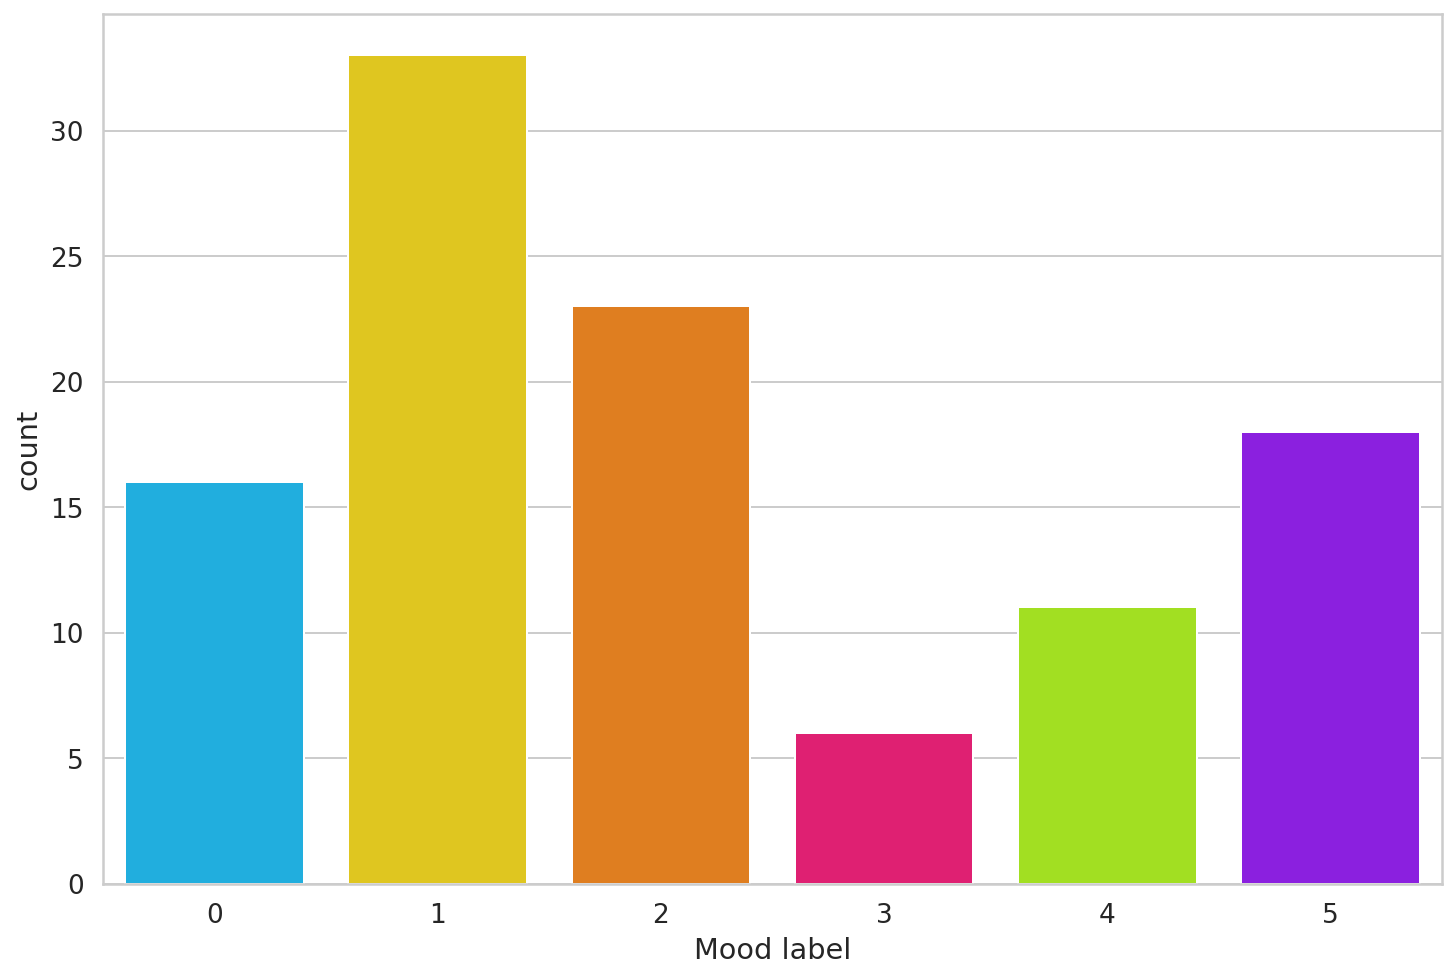

In [20]:
sns.countplot(df.label)
plt.xlabel('Mood label');

In [22]:
def to_mood(rating):
  rating = int(rating)
  if rating == 0:
    return 0
  elif rating == 1:
    return 1
  elif rating == 2:
    return 2
  elif rating == 3:
    return 3  
  elif rating == 4:
    return 4    
  else: 
    return 5

df['mood'] = df.label.apply(to_mood)

In [24]:
class_names = ['বেদনা', 'তৃপ্তি', 'প্রশান্ত', 'বিষণ্ণতা', 'আনন্দ', 'তেজোময়']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/u

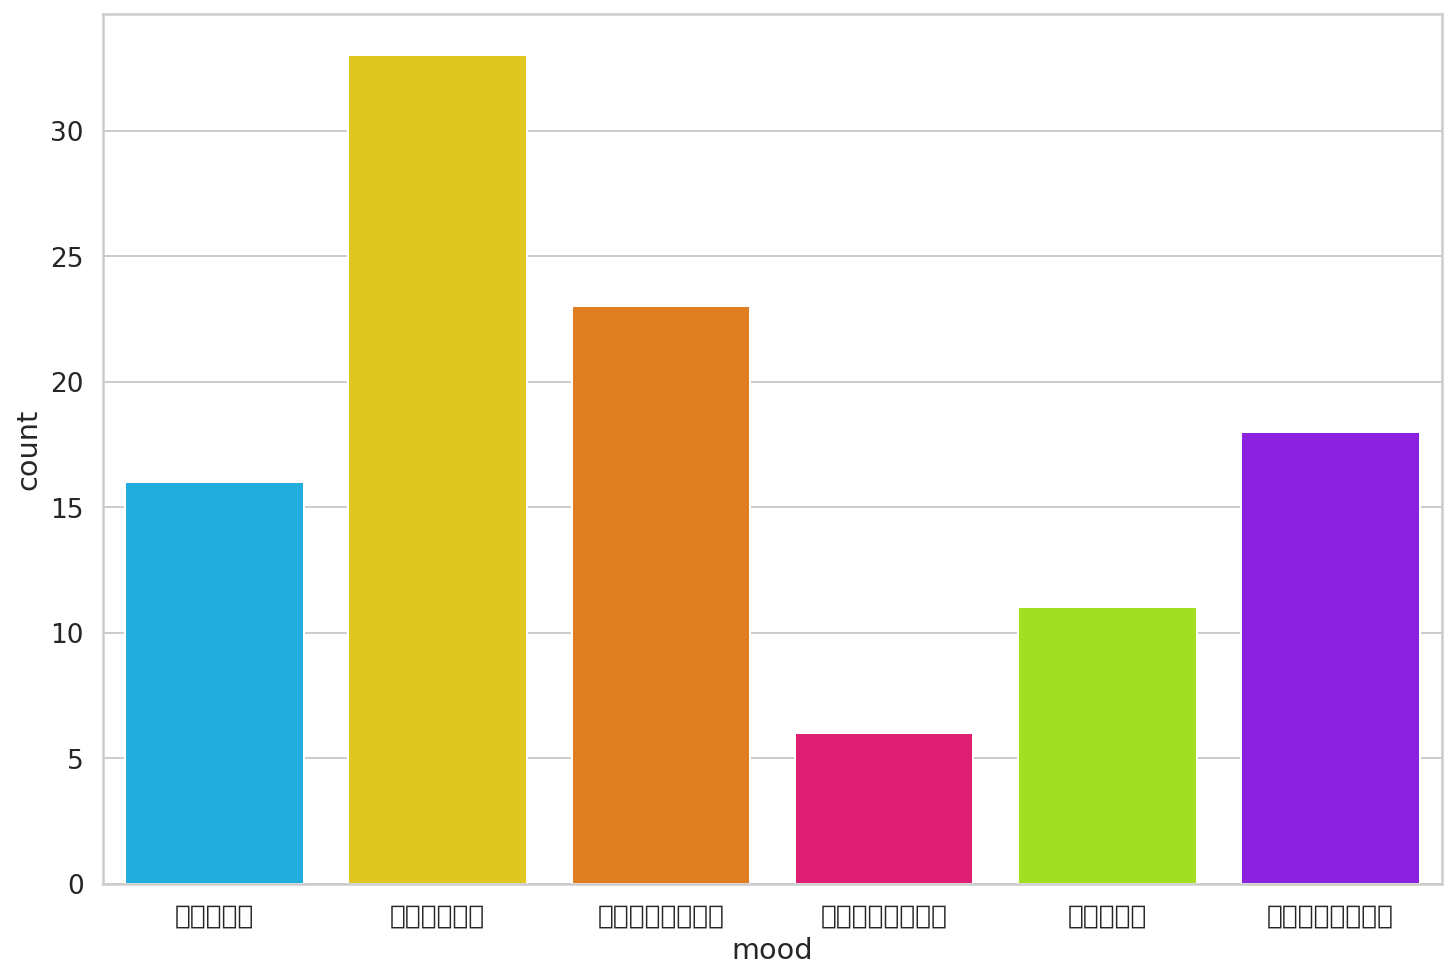

In [25]:
ax = sns.countplot(df.mood)
plt.xlabel('mood')
ax.set_xticklabels(class_names);

In [26]:
PRE_TRAINED_MODEL_NAME = 'sagorsarker/bangla-bert-base'

In [27]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [28]:
sample_txt = 'আমার বেলা যে যায় সাঁঝ-বেলাতে তোমার সুরে সুরে সুর মেলাতে'

In [29]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: আমার বেলা যে যায় সাঁঝ-বেলাতে তোমার সুরে সুরে সুর মেলাতে
   Tokens: ['আমার', 'বেলা', 'যে', 'যা', '##য', 'সা', '##ঝ', '-', 'বেলা', '##তে', 'তে', '##ামা', '##র', 'সরে', 'সরে', 'সর', 'মেলাতে']
Token IDs: [2211, 2918, 2060, 2120, 9294, 3671, 18679, 1012, 2918, 2200, 4058, 40677, 2046, 3956, 3956, 15803, 15686]


In [30]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [31]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [32]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [33]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [34]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [35]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2211,  2918,  2060,  2120,  9294,  3671, 18679,  1012,  2918,
         2200,  4058, 40677,  2046,  3956,  3956, 15803, 15686,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [36]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [37]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'আমার',
 'বেলা',
 'যে',
 'যা',
 '##য',
 'সা',
 '##ঝ',
 '-',
 'বেলা',
 '##তে',
 'তে',
 '##ামা',
 '##র',
 'সরে',
 'সরে',
 'সর',
 'মেলাতে',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [38]:
token_lens = []

for txt in df.lyrics:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


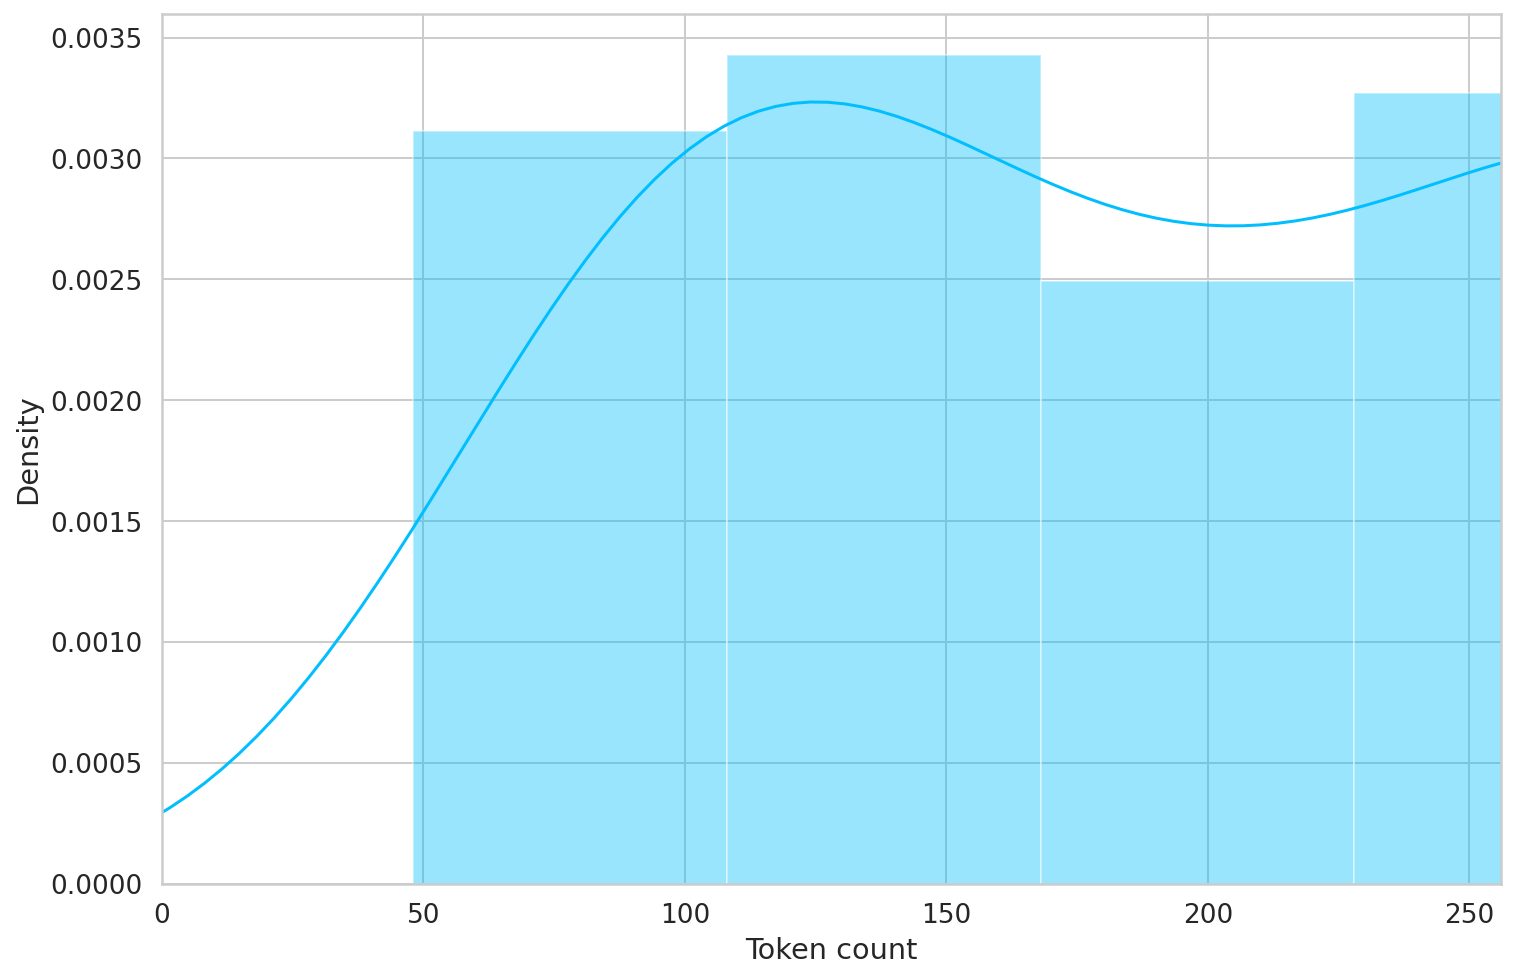

In [39]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [41]:
MAX_LEN = 500
BATCH_SIZE = 6
EPOCHS = 50

In [42]:
class GPReviewDataset(Dataset):

  def __init__(self, lyrics, targets, tokenizer, max_len):
    self.lyrics = lyrics
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.lyrics)
  
  def __getitem__(self, item):
    lyric = str(self.lyrics[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      lyric,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'lyrics_text': lyric,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [43]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [44]:
df_train.shape, df_val.shape, df_test.shape

((85, 5), (11, 5), (11, 5))

In [45]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    lyrics=df.lyrics.to_numpy(),
    targets=df.mood.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [46]:
BATCH_SIZE = 6

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [47]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['lyrics_text', 'input_ids', 'attention_mask', 'targets'])

In [48]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([6, 500])
torch.Size([6, 500])
torch.Size([6])


In [49]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [50]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [51]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [52]:
bert_model.config.hidden_size

768

In [53]:
pooled_output.shape

torch.Size([1, 768])

In [54]:

class MoodClassifier(nn.Module):

  def __init__(self, n_classes):
    super(MoodClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [55]:
model = MoodClassifier(len(class_names))
model = model.to(device)

In [56]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([6, 500])
torch.Size([6, 500])


In [57]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1827, 0.0968, 0.2163, 0.1262, 0.1755, 0.2025],
        [0.2182, 0.1152, 0.1679, 0.1873, 0.1163, 0.1951],
        [0.1755, 0.1229, 0.1931, 0.1078, 0.2059, 0.1947],
        [0.1539, 0.1268, 0.1892, 0.1385, 0.2144, 0.1773],
        [0.2338, 0.0801, 0.2395, 0.1454, 0.1613, 0.1398],
        [0.1237, 0.1273, 0.1975, 0.1830, 0.2315, 0.1369]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [58]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [59]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [60]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [61]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.9197042385737102 accuracy 0.16470588235294117
Val   loss 2.0142555236816406 accuracy 0.2727272727272727

Epoch 2/10
----------
Train loss 1.8663454055786133 accuracy 0.21176470588235294
Val   loss 2.029993712902069 accuracy 0.2727272727272727

Epoch 3/10
----------
Train loss 1.9009162664413453 accuracy 0.23529411764705882
Val   loss 1.990113914012909 accuracy 0.2727272727272727

Epoch 4/10
----------
Train loss 1.787174367904663 accuracy 0.18823529411764706
Val   loss 1.9505996108055115 accuracy 0.2727272727272727

Epoch 5/10
----------
Train loss 1.687189269065857 accuracy 0.2823529411764706
Val   loss 1.8979589939117432 accuracy 0.2727272727272727

Epoch 6/10
----------
Train loss 1.7571919202804565 accuracy 0.24705882352941178
Val   loss 1.8884060382843018 accuracy 0.2727272727272727

Epoch 7/10
----------
Train loss 1.720288880666097 accuracy 0.29411764705882354
Val   loss 1.88825523853302 accuracy 0.2727272727272727

Epoch 8/10
----------
Train 

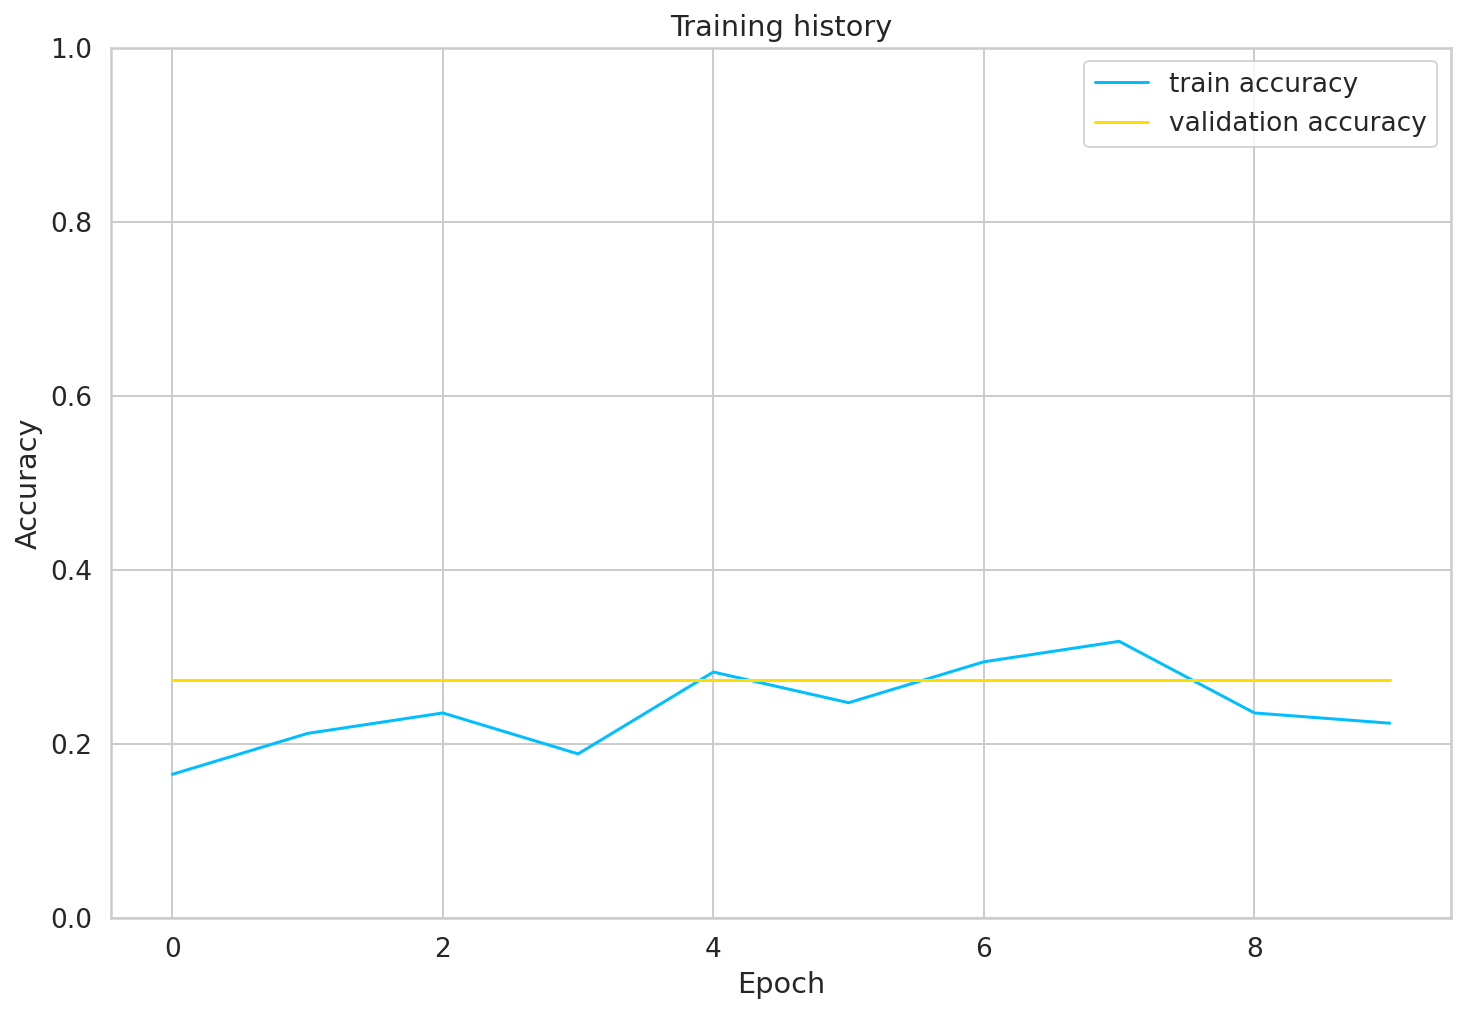

In [62]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [63]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.5454545454545454

In [64]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  lyrics_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["lyrics_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      lyrics_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return lyrics_texts, predictions, prediction_probs, real_values

In [65]:
y_lyrics_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [66]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       বেদনা       0.00      0.00      0.00         1
      তৃপ্তি       0.55      1.00      0.71         6
    প্রশান্ত       0.00      0.00      0.00         1
    বিষণ্ণতা       0.00      0.00      0.00         1
       আনন্দ       0.00      0.00      0.00         1
    তেজোময়       0.00      0.00      0.00         1

    accuracy                           0.55        11
   macro avg       0.09      0.17      0.12        11
weighted avg       0.30      0.55      0.39        11



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2468 missing from current font.
  font.set_text(s

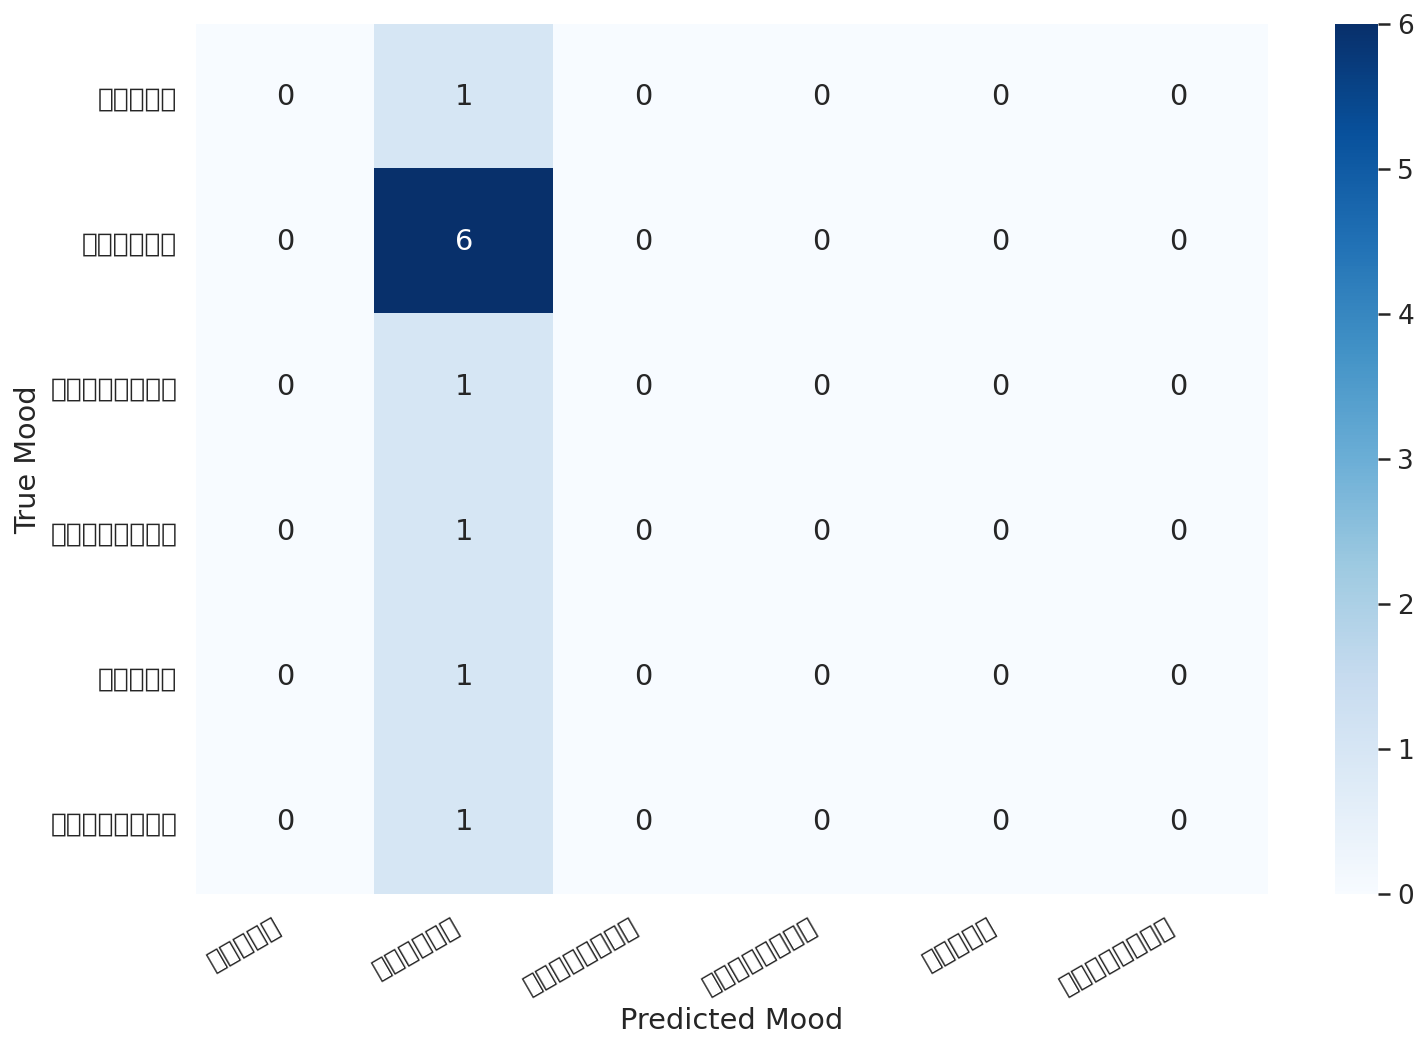

In [67]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Mood')
  plt.xlabel('Predicted Mood');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [68]:
idx = 2

lyric_text = y_lyrics_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [69]:
print("\n".join(wrap(lyric_text)))
print()
print(f'True Mood: {class_names[true_sentiment]}')

হো হো হো আ হা হা  আ আ আ, যানিনা সে হৃদয়ে কখন এসেছে, প্রানের মাঝে দোলা
দিয়েছে, আমার এ মন কারে যেন ভালবেসেছে। আমার এ মন কারে যেন ভালবেসেছে।
হো হো হো আ আ আ– যানিনা সে হৃদয়ে কখন এসেছে, প্রানের মাঝে দোলা দিয়েছে,
আমার এ মন কারে যেন ভালবেসেছে। আমার এ মন কারে যেন ভালবেসেছে।  আকাশে
দেখি কতো স্বপ্ন, মেঘে মেঘে আনে মায়া লগ্ন। আকাশে দেখি কতো স্বপ্ন, মেঘে
মেঘে আনে মায়া লগ্ন।  পাখীর কাকলীতে বুজি সে আজ, পাখীর কাকলীতে বুজি সে
আজ, কতো কথা বলে গিয়েছে- আমার এ মন কারে যেন ভালবেসেছে। যানিনা সে হৃদয়ে
কখন এসেছে, প্রানের মাঝে দোলা দিয়েছে, আমার এ মন কারে যেন ভালবেসেছে।
আমার এ মন কারে যেন ভালবেসেছে। হো হো হো আ হা হা  আ আ আ,  আমায় সে চায়
তবু চায় না, তারে কেন ধরে রাখা যায় না। আমায় সে চায় তবু চায় না, তারে কেন
ধরে রাখা যায় না।  জীবন মরণেতে আমি যে তার, জীবন মরণেতে আমি যে তার, সে
কি তবে যেনে নিয়েছে– আমার এ মন কারে যেন ভালবেসেছে।  যানিনা সে হৃদয়ে কখন
এসেছে, প্রানের মাঝে দোলা দিয়েছে, আমার এ মন কারে যেন ভালবেসেছে। আমার এ
মন কারে যেন ভালবেসেছে। ও হো হো আ হা হা আ আ আ—

True Mood: তেজোময়


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2468 missing from current font.
  font.set_text(s

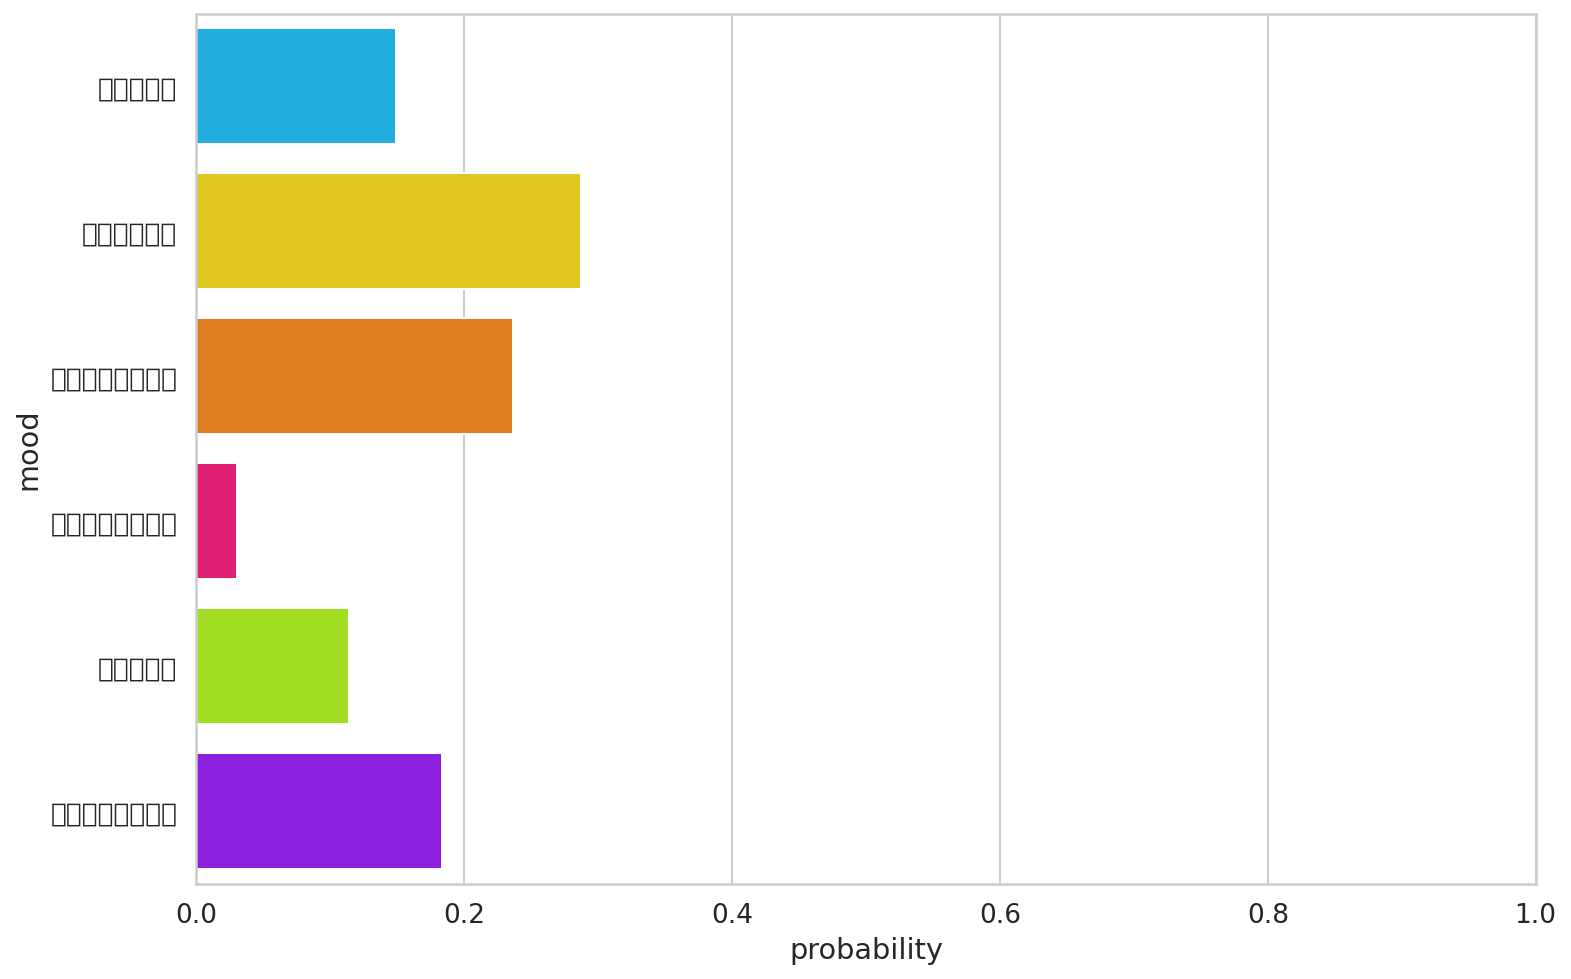

In [70]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('mood')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [71]:
lyric_text = "এই লভিনু সঙ্গ তব, সুন্দর হে সুন্দর !পুণ্য হল অঙ্গ মম, ধন্য হল অন্তর  সুন্দর হে সুন্দর॥ আলোকে মোর চক্ষুদুটি মুগ্ধ হয়ে উঠল ফুটি, হৃদ্‌গগনে পবন হল সৌরভেতে মন্থর   সুন্দর হে সুন্দর॥ এই তোমারি পরশরাগে চিত্ত হল রঞ্জিত, এই তোমারি মিলনসুধা রইল প্রাণে সঞ্চিত।  তোমার মাঝে এমনি ক’রে  নবীন করি লও যে মোরে এই জনমে ঘটালে মোর জন্ম-জনমান্তর   সুন্দর হে সুন্দর॥"

In [72]:
encoded_review = tokenizer.encode_plus(
  lyric_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [73]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'lyrics text: {lyric_text}')
print(f'mood  : {class_names[prediction]}')

lyrics text: এই লভিনু সঙ্গ তব, সুন্দর হে সুন্দর !পুণ্য হল অঙ্গ মম, ধন্য হল অন্তর  সুন্দর হে সুন্দর॥ আলোকে মোর চক্ষুদুটি মুগ্ধ হয়ে উঠল ফুটি, হৃদ্‌গগনে পবন হল সৌরভেতে মন্থর   সুন্দর হে সুন্দর॥ এই তোমারি পরশরাগে চিত্ত হল রঞ্জিত, এই তোমারি মিলনসুধা রইল প্রাণে সঞ্চিত।  তোমার মাঝে এমনি ক’রে  নবীন করি লও যে মোরে এই জনমে ঘটালে মোর জন্ম-জনমান্তর   সুন্দর হে সুন্দর॥
mood  : তৃপ্তি


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/testModel')

ModuleAttributeError: ignored